In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc
import scipy.constants as sc

In [2]:
def generate_delta_sampling(delta_min, delta_max, step=None, num_points=None):
    if step is None and num_points is None:
        raise ValueError("Either 'step' or 'num_points' must be provided.")
    if step is None:
        step = (delta_max - delta_min) / num_points

    i_min = int(np.ceil(delta_min / step))
    i_max = int(np.floor(delta_max / step))

    arr = step * np.arange(i_min, i_max + 1)
    return arr

In [3]:
def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    tw = line.twiss()
    tt = line.get_table()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

In [4]:
def twiss_scan(line, delta_min, delta_max, step=None, num_points=None):
    delta_values = generate_delta_sampling(delta_min, delta_max, step, num_points)
    
    idx_zero = np.where(delta_values == 0)[0][0]
    tw0 = line.twiss4d(delta0=0.0)
    twisses = []
    # twiss_pos.append(tw0)
    # twiss_neg.append(tw0)

    for delta in delta_values[:idx_zero][::-1]:
        twisses.append(line.twiss4d(delta0=delta, co_guess=twisses[-1].particle_on_co) if len(twisses)>0 else tw0)
    twisses = twisses[::-1]
    twisses.append(tw0)
    for delta in delta_values[idx_zero + 1:]:
        twisses.append(line.twiss4d(delta0=delta, co_guess=twisses[-1].particle_on_co))
    
    return delta_values, twisses

In [5]:
def plot_x(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc, savename=None):
    fig, ax = plt.subplots(1,1, figsize=(8,6))

    idx_zero_lin = np.where(delta_values_lin == 0)[0][0]
    idx_zero_errs = np.where(delta_values_errs == 0)[0][0]

    errs_neg = np.array([twiss.rows[loc].x[0] for twiss in twisses_errs[:idx_zero_errs+1]])
    errs_pos = np.array([twiss.rows[loc].x[0] for twiss in twisses_errs[idx_zero_errs:]])
    lin_neg = np.array([twiss.rows[loc].x[0] for twiss in twisses_lin[:idx_zero_lin+1]])
    lin_pos = np.array([twiss.rows[loc].x[0] for twiss in twisses_lin[idx_zero_lin:]])

    ax.plot(-delta_values_lin[:idx_zero_lin+1], -lin_neg, color='red', label=f'{loc} - without errors')
    ax.plot(delta_values_lin[idx_zero_lin:], lin_pos, color='blue', label=f'{loc} + without errors')

    ax.plot(-delta_values_errs[:idx_zero_errs+1], -errs_neg, color='red', linestyle='--', label=f'{loc} - with errors')
    ax.plot(delta_values_errs[idx_zero_errs:], errs_pos, color='blue', linestyle='--', label=f'{loc} + with errors')
    ax.set_xlabel('δ')
    ax.set_ylabel(f'x [m]')
    # ax.set_title(f'{loc} position vs Momentum Deviation')
    ax.grid()
    ax.legend()
    ax.set_title(f'{loc}')
    fig.tight_layout()
    if savename is not None:
        fig.savefig(f'{savename}.png', dpi=300)
    
    return fig, ax

In [6]:
def plot_dx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc, savename=None):
    fig, ax = plt.subplots(1,1, figsize=(8,6))

    idx_zero_lin = np.where(delta_values_lin == 0)[0][0]
    idx_zero_errs = np.where(delta_values_errs == 0)[0][0]

    errs_neg = np.array([twiss.rows[loc].dx[0] for twiss in twisses_errs[:idx_zero_errs+1]])
    errs_pos = np.array([twiss.rows[loc].dx[0] for twiss in twisses_errs[idx_zero_errs:]])
    lin_neg = np.array([twiss.rows[loc].dx[0] for twiss in twisses_lin[:idx_zero_lin+1]])
    lin_pos = np.array([twiss.rows[loc].dx[0] for twiss in twisses_lin[idx_zero_lin:]])
    
    ax.plot(-delta_values_lin[:idx_zero_lin+1], -lin_neg + lin_neg[-1] + lin_pos[0], color='red', label=f'{loc} - without errors')
    ax.plot(delta_values_lin[idx_zero_lin:], lin_pos, color='blue', label=f'{loc} + without errors')

    ax.plot(-delta_values_errs[:idx_zero_errs+1], -errs_neg + errs_neg[-1] + errs_pos[0], color='red', linestyle='--', label=f'{loc} - with errors')
    ax.plot(delta_values_errs[idx_zero_errs:], errs_pos, color='blue', linestyle='--', label=f'{loc} + with errors')
    ax.set_xlabel('δ')
    ax.set_ylabel(f'Dx [m]')
    # ax.set_title(f'{loc} position vs Momentum Deviation')
    ax.grid()
    ax.legend()
    ax.set_title(f'{loc}')
    fig.tight_layout()
    if savename is not None:
        fig.savefig(f'{savename}.png', dpi=300)
    
    return fig, ax

In [7]:
def plot_ddx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc, savename=None):
    fig, ax = plt.subplots(1,1, figsize=(8,6))

    idx_zero_lin = np.where(delta_values_lin == 0)[0][0]
    idx_zero_errs = np.where(delta_values_errs == 0)[0][0]

    errs_neg = np.array([twiss.rows[loc].ddx[0] for twiss in twisses_errs[:idx_zero_errs+1]])
    errs_pos = np.array([twiss.rows[loc].ddx[0] for twiss in twisses_errs[idx_zero_errs:]])
    lin_neg = np.array([twiss.rows[loc].ddx[0] for twiss in twisses_lin[:idx_zero_lin+1]])
    lin_pos = np.array([twiss.rows[loc].ddx[0] for twiss in twisses_lin[idx_zero_lin:]])
    
    ax.plot(-delta_values_lin[:idx_zero_lin+1], -lin_neg + lin_neg[-1] + lin_pos[0], color='red', label=f'{loc} - without errors')
    ax.plot(delta_values_lin[idx_zero_lin:], lin_pos, color='blue', label=f'{loc} + without errors')

    ax.plot(-delta_values_errs[:idx_zero_errs+1], -errs_neg + errs_neg[-1] + errs_pos[0], color='red', linestyle='--', label=f'{loc} - with errors')
    ax.plot(delta_values_errs[idx_zero_errs:], errs_pos, color='blue', linestyle='--', label=f'{loc} + with errors')
    ax.set_xlabel('δ')
    ax.set_ylabel(f'DDx [m]')
    # ax.set_title(f'{loc} position vs Momentum Deviation')
    ax.grid()
    ax.legend()
    ax.set_title(f'{loc}')
    fig.tight_layout()
    if savename is not None:
        fig.savefig(f'{savename}.png', dpi=300)
    
    return fig, ax

In [8]:
def plot_betx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc, savename=None):
    fig, ax = plt.subplots(1,1, figsize=(8,6))

    idx_zero_lin = np.where(delta_values_lin == 0)[0][0]
    idx_zero_errs = np.where(delta_values_errs == 0)[0][0]

    errs_neg = np.array([twiss.rows[loc].betx[0] for twiss in twisses_errs[:idx_zero_errs+1]])
    errs_pos = np.array([twiss.rows[loc].betx[0] for twiss in twisses_errs[idx_zero_errs:]])
    lin_neg = np.array([twiss.rows[loc].betx[0] for twiss in twisses_lin[:idx_zero_lin+1]])
    lin_pos = np.array([twiss.rows[loc].betx[0] for twiss in twisses_lin[idx_zero_lin:]])
    
    ax.plot(-delta_values_lin[:idx_zero_lin+1], -lin_neg + lin_neg[-1] + lin_pos[0], color='red', label=f'{loc} - without errors')
    ax.plot(delta_values_lin[idx_zero_lin:], lin_pos, color='blue', label=f'{loc} + without errors')

    ax.plot(-delta_values_errs[:idx_zero_errs+1], -errs_neg + errs_neg[-1] + errs_pos[0], color='red', linestyle='--', label=f'{loc} - with errors')
    ax.plot(delta_values_errs[idx_zero_errs:], errs_pos, color='blue', linestyle='--', label=f'{loc} + with errors')
    ax.set_xlabel('δ')
    ax.set_ylabel(f'βx [m]')
    # ax.set_title(f'{loc} position vs Momentum Deviation')
    ax.grid()
    ax.legend()
    ax.set_title(f'{loc}')
    fig.tight_layout()
    if savename is not None:
        fig.savefig(f'{savename}.png', dpi=300)
    
    return fig, ax

# Error line

In [10]:
line = xt.Line.from_json('../../injection_lines/sps_q20_inj.json')
tt = line.get_table()
tw = line.twiss()
env = line.env
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
    line[name].voltage = 0.0
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

# remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           


In [11]:
# Add errors in line
tte = env.elements.get_table()
mask_rbends = tte.element_type == 'RBend'
mask_quads = tte.element_type == 'Quadrupole'
mask_sextupoles = tte.element_type == 'Sextupole'

mba = tte.rows[mask_rbends].rows['mba.*'].name
mbb = tte.rows[mask_rbends].rows['mbb.*'].name
qf = tte.rows[mask_quads].rows['qf.*'].name
qd = tte.rows[mask_quads].rows['qd.*'].name
lsf = tte.rows[mask_sextupoles].rows['lsf.*'].name
lsd = tte.rows[mask_sextupoles].rows['lsd.*'].name

for nn in mba:
    env[nn].knl = np.array([0., 0., 2.12e-3, 0., -5.74, 0.])

for nn in mbb:
    env[nn].knl = np.array([0., 0., -3.19e-3, 0., -5.10, 0.])

for nn in qf:
    env[nn].knl = np.array([0., 0., 0., 0.75e-1, 0., -0.87e3])

for nn in qd:
    env[nn].knl = np.array([0., 0., 0., -2.03e-1, 0., 2.04e3])

In [12]:
# Match tune and chroma
env.vars['qph_setvalue'] = 0.5
env.vars['qpv_setvalue'] = 0.5
qx = 20.13
qy = 20.18
opt = line.match(
    method='6d', # <- passed to twiss
    vary=[
        xt.VaryList(['kqf0', 'kqd0'], step=1e-8, tag='quad'),
        xt.VaryList(['qph_setvalue', 'qpv_setvalue'], step=1e-4, tag='sext'),
    ],
    targets = [
        xt.TargetSet(qx=qx, qy=qy, tol=1e-6, tag='tune'),
        xt.TargetSet(dqx=0.5*qx, dqy=0.5*qy, tol=1e-2, tag='chrom'),
    ])

                                             
Optimize - start penalty: 13.73                             
Matching: model call n. 7 penalty = 2.6216e-03              
Optimize - end penalty:  0.00262155                            


In [13]:
num_points = 2000
step= (0.79e-2 - (-0.79e-2)) / num_points

In [14]:
delta_values_errs, twisses_errs = twiss_scan(line, delta_min=-0.7e-2, delta_max=0.7e-2, step=step)
idx_zero_errs = np.where(delta_values_errs == 0)[0][0]

# Linear line

In [15]:
line = xt.Line.from_json('../../injection_lines/sps_q20_inj.json')
tt = line.get_table()
tw = line.twiss()
env = line.env
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
    line[name].voltage = 0.0
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

# remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           


In [ ]:
# Match tune and chroma
env.vars['qph_setvalue'] = 0.5
env.vars['qpv_setvalue'] = 0.5
qx = 20.13
qy = 20.18
opt = line.match(
    method='6d', # <- passed to twiss
    vary=[
        xt.VaryList(['kqf0', 'kqd0'], step=1e-8, tag='quad'),
        xt.VaryList(['qph_setvalue', 'qpv_setvalue'], step=1e-4, tag='sext'),
    ],
    targets = [
        xt.TargetSet(qx=qx, qy=qy, tol=1e-6, tag='tune'),
        xt.TargetSet(dqx=0.5*qx, dqy=0.5*qy, tol=1e-2, tag='chrom'),
    ])

                                             
Optimize - start penalty: 1.178                             
Matching: model call n. 7 penalty = 3.4867e-04              
Optimize - end penalty:  0.000348674                            


In [16]:
num_points = 2000
step= (1e-2 - (-1e-2)) / num_points

In [18]:
delta_values_lin, twisses_lin = twiss_scan(line, delta_min=-1e-2, delta_max=1e-2, step=step)
idx_zero_lin = np.where(delta_values_lin == 0)[0][0]

# Plots

In [17]:
tw = line.twiss()

## Loss locations for sweep

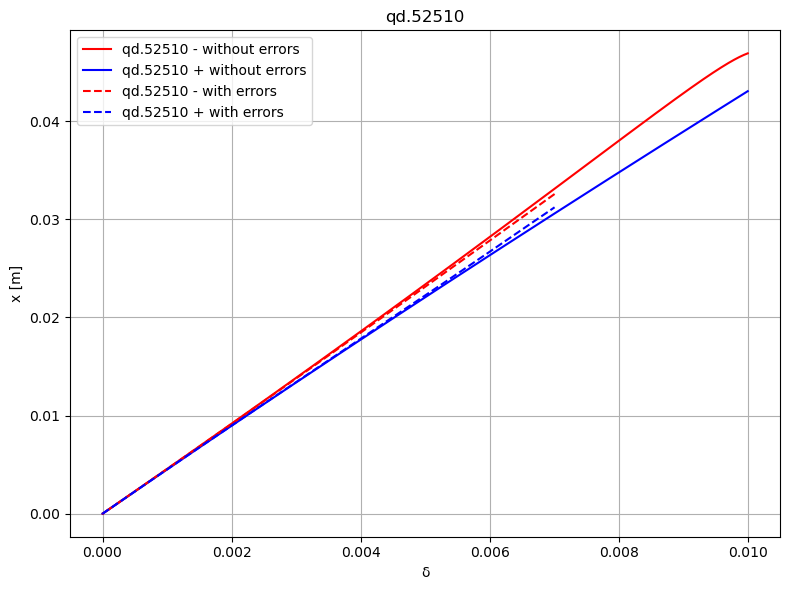

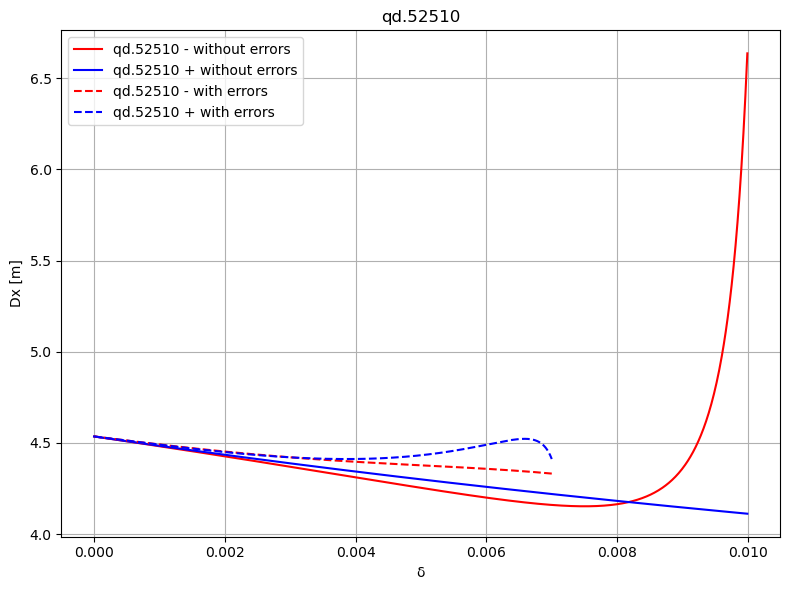

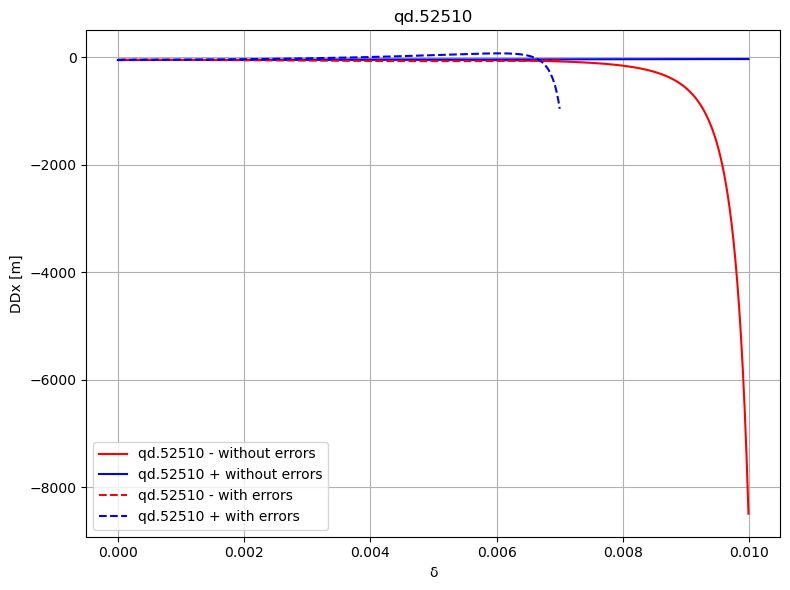

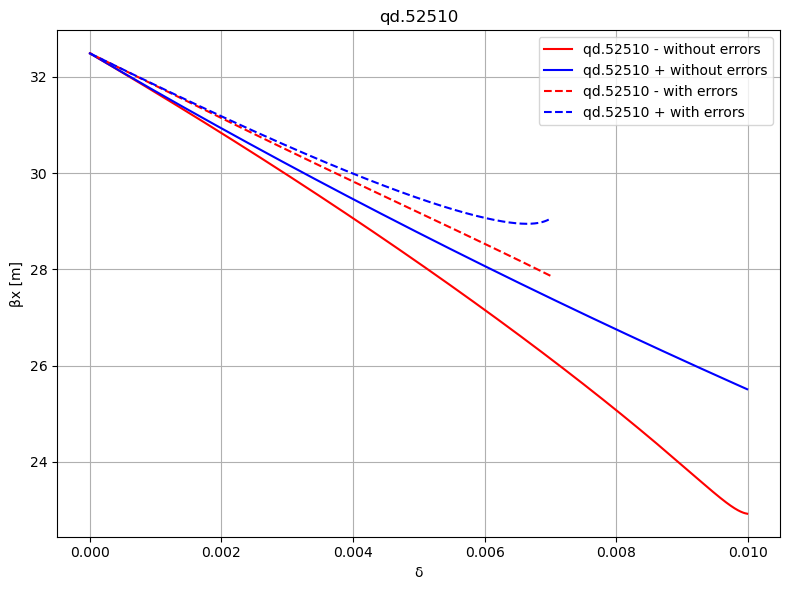

In [19]:
loc = 'qd.52510'
fig, ax = plot_x(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc = loc, savename=f'Figures/{loc}_x')
fig, ax = plot_dx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc = loc, savename=f'Figures/{loc}_dx')
fig, ax = plot_ddx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc = loc, savename=f'Figures/{loc}_ddx')
fig, ax = plot_betx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc = loc, savename=f'Figures/{loc}_betx')

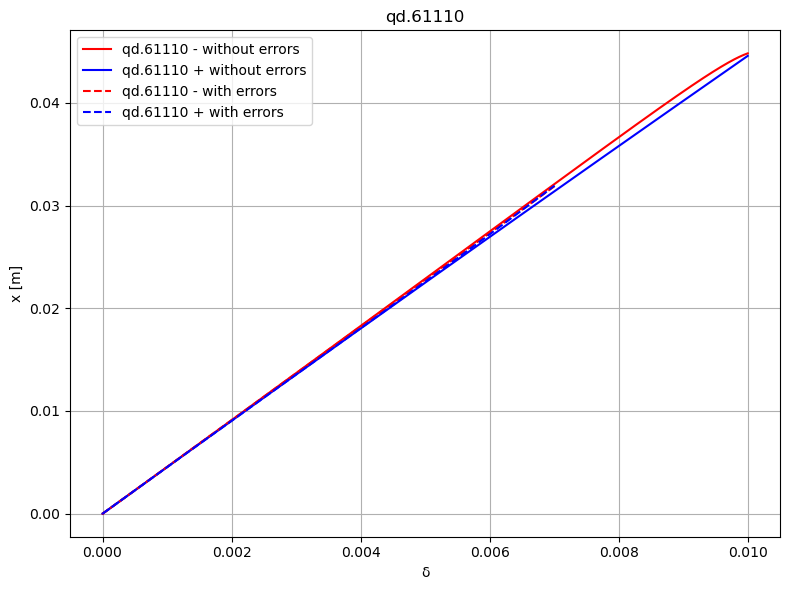

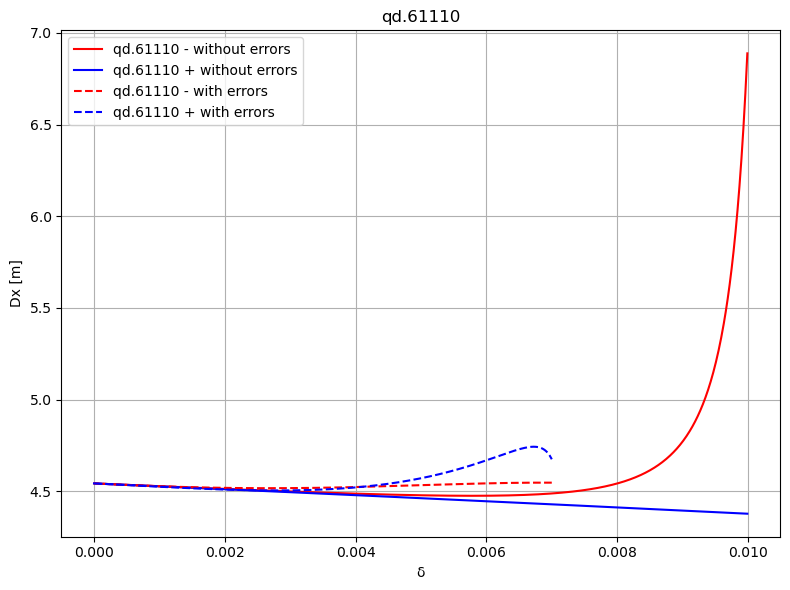

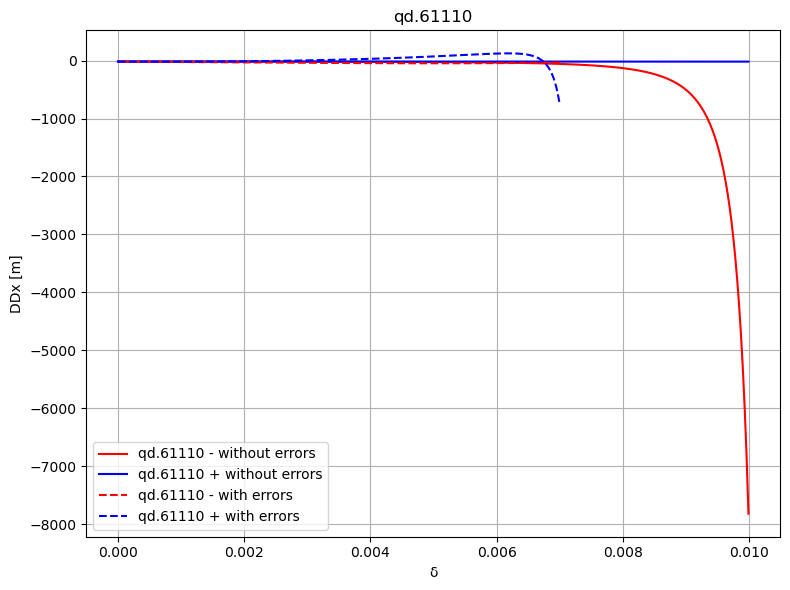

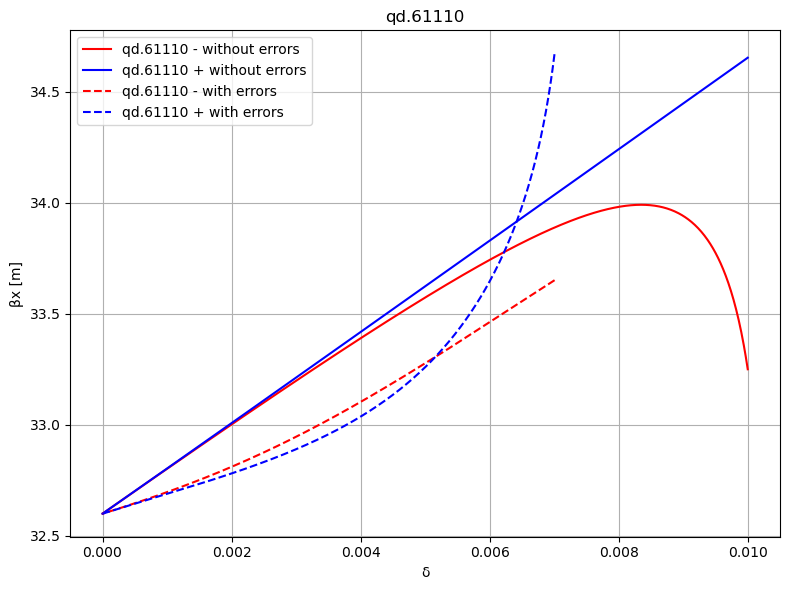

In [20]:
loc = 'qd.61110'
fig, ax = plot_x(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc = loc, savename=f'Figures/{loc}_x')
fig, ax = plot_dx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc = loc, savename=f'Figures/{loc}_dx')
fig, ax = plot_ddx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc = loc, savename=f'Figures/{loc}_ddx')
fig, ax = plot_betx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, loc = loc, savename=f'Figures/{loc}_betx')

## Mixed plots

In [27]:
def plot_x(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, locs, savename=None):
    fig, ax = plt.subplots(1,1, figsize=(8,6))

    idx_zero_lin = np.where(delta_values_lin == 0)[0][0]
    idx_zero_errs = np.where(delta_values_errs == 0)[0][0]

    if len(locs) == 1:
        locs = [locs[0], locs[0]]
        title = locs[0]
    else:
        title = f'Comparison {locs[0]} (negative bottleneck) and {locs[1]} (positive bottleneck)'

    errs_neg = np.array([twiss.rows[locs[0]].x[0] for twiss in twisses_errs[:idx_zero_errs+1]])
    errs_pos = np.array([twiss.rows[locs[1]].x[0] for twiss in twisses_errs[idx_zero_errs:]])
    lin_neg = np.array([twiss.rows[locs[0]].x[0] for twiss in twisses_lin[:idx_zero_lin+1]])
    lin_pos = np.array([twiss.rows[locs[1]].x[0] for twiss in twisses_lin[idx_zero_lin:]])

    ax.plot(-delta_values_lin[:idx_zero_lin+1], -lin_neg, color='red', label=f'{loc[0]} - without errors')
    ax.plot(delta_values_lin[idx_zero_lin:], lin_pos, color='blue', label=f'{locs[1]} + without errors')

    ax.plot(-delta_values_errs[:idx_zero_errs+1], -errs_neg, color='red', linestyle='--', label=f'{locs[0]} - with errors')
    ax.plot(delta_values_errs[idx_zero_errs:], errs_pos, color='blue', linestyle='--', label=f'{locs[1]} + with errors')
    ax.set_xlabel('δ')
    ax.set_ylabel(f'x [m]')
    # ax.set_title(f'{loc} position vs Momentum Deviation')
    ax.grid()
    ax.legend()
    ax.set_title(f'{title}')
    fig.tight_layout()
    if savename is not None:
        fig.savefig(f'{savename}.png', dpi=300)
    
    return fig, ax

In [22]:
def plot_dx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, locs, savename=None):
    fig, ax = plt.subplots(1,1, figsize=(8,6))

    idx_zero_lin = np.where(delta_values_lin == 0)[0][0]
    idx_zero_errs = np.where(delta_values_errs == 0)[0][0]

    if len(locs) == 1:
        locs = [locs[0], locs[0]]
        title = locs[0]
    else:
        title = f'Comparison {locs[0]} (negative bottleneck) and {locs[1]} (positive bottleneck)'

    errs_neg = np.array([twiss.rows[locs[0]].dx[0] for twiss in twisses_errs[:idx_zero_errs+1]])
    errs_pos = np.array([twiss.rows[locs[1]].dx[0] for twiss in twisses_errs[idx_zero_errs:]])
    lin_neg = np.array([twiss.rows[locs[0]].dx[0] for twiss in twisses_lin[:idx_zero_lin+1]])
    lin_pos = np.array([twiss.rows[locs[1]].dx[0] for twiss in twisses_lin[idx_zero_lin:]])
    
    ax.plot(-delta_values_lin[:idx_zero_lin+1], -lin_neg + lin_neg[-1] + lin_pos[0], color='red', label=f'{locs[0]} - without errors')
    ax.plot(delta_values_lin[idx_zero_lin:], lin_pos, color='blue', label=f'{locs[1]} + without errors')

    ax.plot(-delta_values_errs[:idx_zero_errs+1], -errs_neg + errs_neg[-1] + errs_pos[0], color='red', linestyle='--', label=f'{locs[0]} - with errors')
    ax.plot(delta_values_errs[idx_zero_errs:], errs_pos, color='blue', linestyle='--', label=f'{locs[1]} + with errors')
    ax.set_xlabel('δ')
    ax.set_ylabel(f'Dx [m]')
    # ax.set_title(f'{loc} position vs Momentum Deviation')
    ax.grid()
    ax.legend()
    ax.set_title(f'{title}')
    fig.tight_layout()
    if savename is not None:
        fig.savefig(f'{savename}.png', dpi=300)
    
    return fig, ax

In [24]:
def plot_ddx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, locs, savename=None):
    fig, ax = plt.subplots(1,1, figsize=(8,6))

    idx_zero_lin = np.where(delta_values_lin == 0)[0][0]
    idx_zero_errs = np.where(delta_values_errs == 0)[0][0]

    if len(locs) == 1:
        locs = [locs[0], locs[0]]
        title = locs[0]
    else:
        title = f'Comparison {locs[0]} (negative bottleneck) and {locs[1]} (positive bottleneck)'
    
    errs_neg = np.array([twiss.rows[locs[0]].ddx[0] for twiss in twisses_errs[:idx_zero_errs+1]])
    errs_pos = np.array([twiss.rows[locs[1]].ddx[0] for twiss in twisses_errs[idx_zero_errs:]])
    lin_neg = np.array([twiss.rows[locs[0]].ddx[0] for twiss in twisses_lin[:idx_zero_lin+1]])
    lin_pos = np.array([twiss.rows[locs[1]].ddx[0] for twiss in twisses_lin[idx_zero_lin:]])
    
    ax.plot(-delta_values_lin[:idx_zero_lin+1], -lin_neg + lin_neg[-1] + lin_pos[0], color='red', label=f'{locs[0]} - without errors')
    ax.plot(delta_values_lin[idx_zero_lin:], lin_pos, color='blue', label=f'{locs[1]} + without errors')

    ax.plot(-delta_values_errs[:idx_zero_errs+1], -errs_neg + errs_neg[-1] + errs_pos[0], color='red', linestyle='--', label=f'{locs[0]} - with errors')
    ax.plot(delta_values_errs[idx_zero_errs:], errs_pos, color='blue', linestyle='--', label=f'{locs[1]} + with errors')
    ax.set_xlabel('δ')
    ax.set_ylabel(f'DDx [m]')
    # ax.set_title(f'{loc} position vs Momentum Deviation')
    ax.grid()
    ax.legend()
    ax.set_title(f'{title}')
    fig.tight_layout()
    if savename is not None:
        fig.savefig(f'{savename}.png', dpi=300)
    
    return fig, ax

In [25]:
def plot_betx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, locs, savename=None):
    fig, ax = plt.subplots(1,1, figsize=(8,6))

    idx_zero_lin = np.where(delta_values_lin == 0)[0][0]
    idx_zero_errs = np.where(delta_values_errs == 0)[0][0]

    if len(locs) == 1:
        locs = [locs[0], locs[0]]
        title = locs[0]
    else:
        title = f'Comparison {locs[0]} (negative bottleneck) and {locs[1]} (positive bottleneck)'

    errs_neg = np.array([twiss.rows[locs[0]].betx[0] for twiss in twisses_errs[:idx_zero_errs+1]])
    errs_pos = np.array([twiss.rows[locs[1]].betx[0] for twiss in twisses_errs[idx_zero_errs:]])
    lin_neg = np.array([twiss.rows[locs[0]].betx[0] for twiss in twisses_lin[:idx_zero_lin+1]])
    lin_pos = np.array([twiss.rows[locs[1]].betx[0] for twiss in twisses_lin[idx_zero_lin:]])
    
    ax.plot(-delta_values_lin[:idx_zero_lin+1], -lin_neg + lin_neg[-1] + lin_pos[0], color='red', label=f'{locs[0]} - without errors')
    ax.plot(delta_values_lin[idx_zero_lin:], lin_pos, color='blue', label=f'{locs[1]} + without errors')

    ax.plot(-delta_values_errs[:idx_zero_errs+1], -errs_neg + errs_neg[-1] + errs_pos[0], color='red', linestyle='--', label=f'{locs[0]} - with errors')
    ax.plot(delta_values_errs[idx_zero_errs:], errs_pos, color='blue', linestyle='--', label=f'{locs[1]} + with errors')
    ax.set_xlabel('δ')
    ax.set_ylabel(f'βx [m]')
    # ax.set_title(f'{loc} position vs Momentum Deviation')
    ax.grid()
    ax.legend()
    ax.set_title(f'{title}')
    fig.tight_layout()
    if savename is not None:
        fig.savefig(f'{savename}.png', dpi=300)
    
    return fig, ax

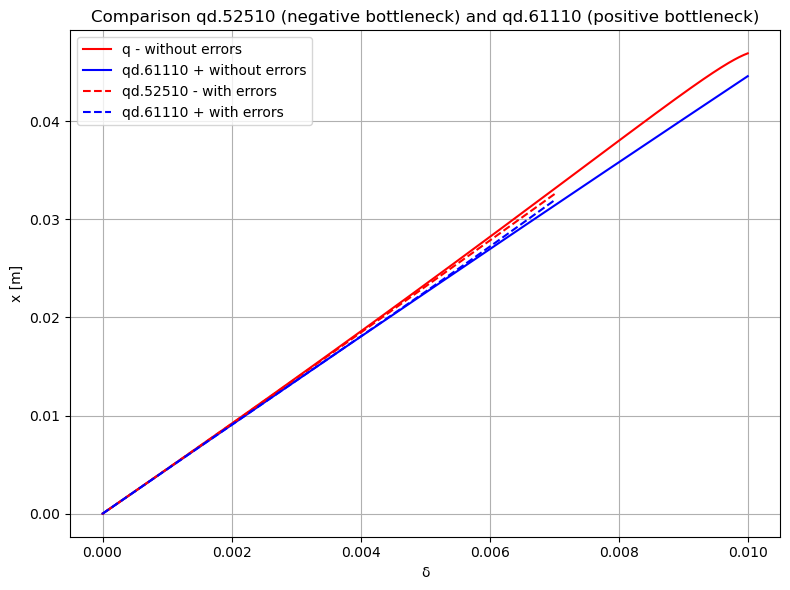

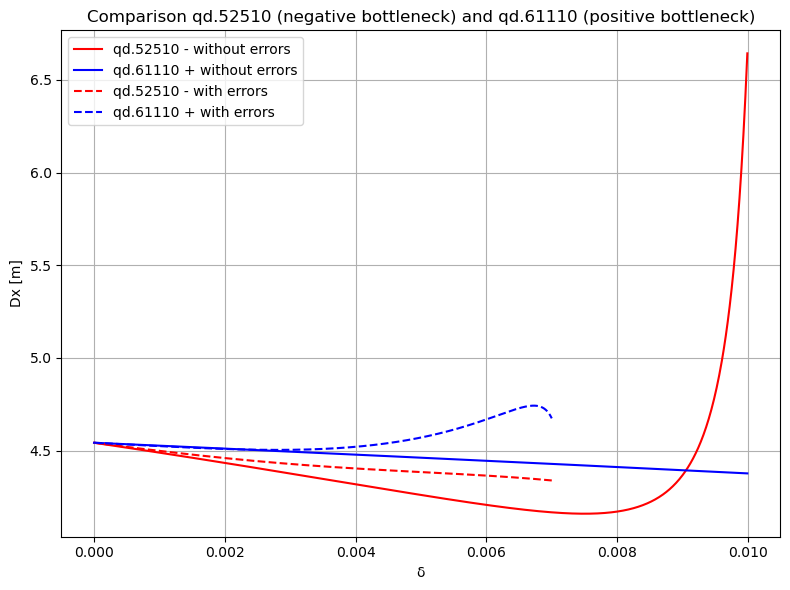

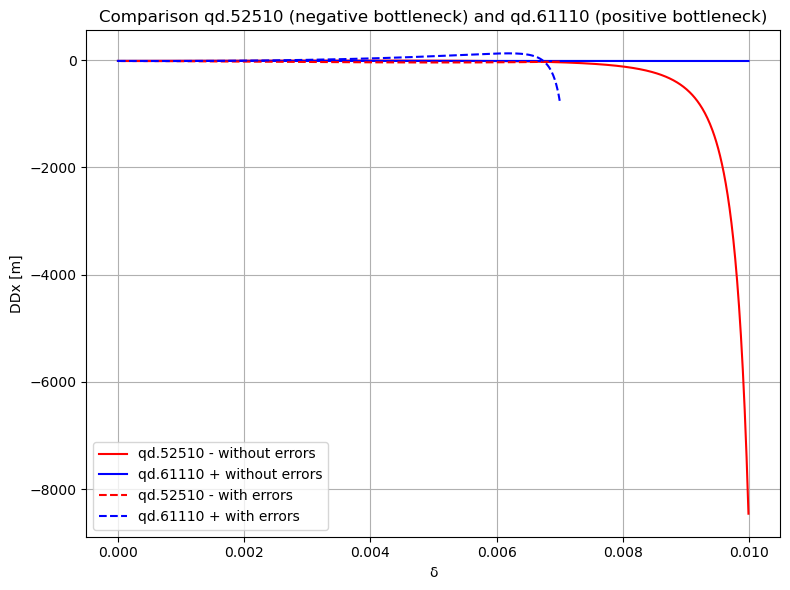

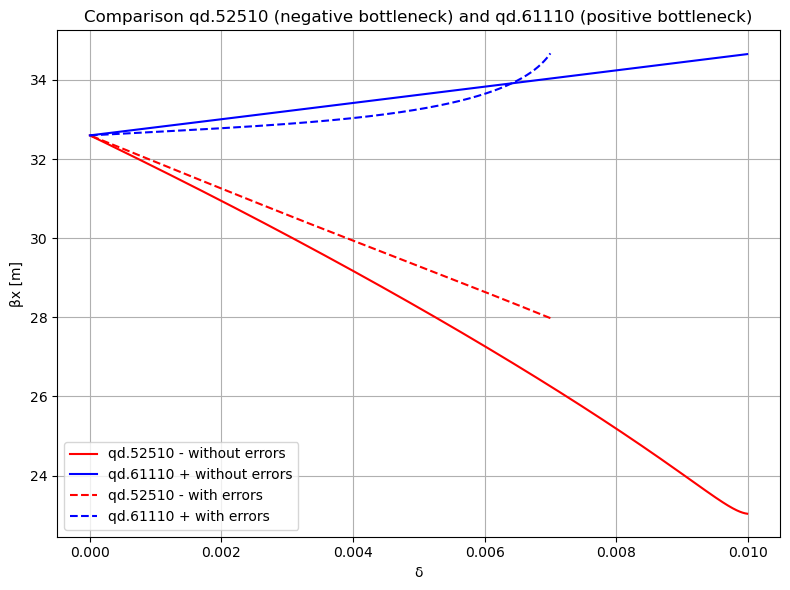

In [28]:
locs = ['qd.52510', 'qd.61110']
fig, ax = plot_x(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, locs = locs, savename=f'Figures/{locs[0]}_{locs[1]}_x')
fig, ax = plot_dx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, locs = locs, savename=f'Figures/{locs[0]}_{locs[1]}_dx')
fig, ax = plot_ddx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, locs = locs, savename=f'Figures/{locs[0]}_{locs[1]}_ddx')
fig, ax = plot_betx(delta_values_lin, delta_values_errs, twisses_lin, twisses_errs, locs = locs, savename=f'Figures/{locs[0]}_{locs[1]}_betx')